# Introduction to using Optuna for Hyper Parameter Optimization with PyTorch and MNIST on Amazon SageMaker

This notebook covers how we perform HyperParameter Optimization using Optuna and its reference architecture in Amazon SageMaker.

Amazon SageMaker supports various frameworks and interfaces such as TensorFlow, Apache MXNet, PyTorch, scikit-learn, Horovod, Keras, and Gluon. The service offers ways to build, train, and deploy machine learning models to all developers and data scientists. Amazon SageMaker offers managed Jupyter Notebook and JupyterLab as well as containerized environments for training and deployment. The service also offers an Automatic Model Tuning with Bayesian HPO feature by default.

In [ ]:
# When you do SageMaker Automatic Model Tuning, 
# Below are the sample codeset


# First define a search space beforehand performing HPO like this
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter
hyperparameter_ranges = {'optimizer': CategoricalParameter(['sgd', 'Adam']),
                         'learning_rate': ContinuousParameter(0.01, 0.2),
                         'num_epoch': IntegerParameter(10, 50)}

# Then you feed it to the HyperparameterTuner class and start training
objective_metric_name = 'Validation-accuracy'
metric_definitions = [{'Name': 'Validation-accuracy',
                   	'Regex': 'Validation-accuracy=([0-9\\.]+)'}]

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=9,
                            max_parallel_jobs=3)
tuner.fit({'train': train_data_location, 'test': test_data_location})

## (Regular Case) Using Optuna for Hyper Parameter Optimization 

You can write HPO using eager APIs in Optuna. This allows you to simplify the code when optimizing the number of the layer of neural networks. For example, if you pre-define a complicated parameter namespace to search each branch of network structure per selected number of layers, the computational load can be heavy. However, you can use Optuna in eager mode to write HPO intuitively. You can define the model as shown in the following code. The trial is the parameter set defined by Optuna. Using this parameter, you can obtain the parameters of the HPO.

In [ ]:
def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []
 
    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_uniform("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))
 
        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))
 
    return nn.Sequential(*layers)

To use Optuna, you can define an objective function **objective()** inside of a training script so that it returns the value you want to maximize or minimize. See the following code:

In [ ]:
def objective(trial):
 
    # Generate the model.
    model = define_model(trial).to(DEVICE)
 
    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_loguniform("lr_{}".format(optimizer_name), 1e-5, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
 
    # Get the MNIST dataset.
    train_loader, test_loader = get_mnist(args)
 
    # Training of the model.
    model.train()
    for epoch in range(EPOCHS):
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break
 
            data, target = data.view(-1, 28 * 28).to(DEVICE), target.to(DEVICE)
 
            # Zeroing out gradient buffers.
            optimizer.zero_grad()
            # Performing a forward pass.
            output = model(data)
            # Computing negative Log Likelihood loss.
            loss = F.nll_loss(output, target)
            # Performing a backward pass.
            loss.backward()
            # Updating the weights.
            optimizer.step()
 
    save_model(model, '/tmp', trial.number)
    …
    return accuracy

In each execution, parameters are selected by the expression **n_layers = trial.suggest_int('n_layers', 1, 3)** in the **define_model(trial)** function. You similarly define **optimizer**. This line selects the optimization method and learning rate.

You can execute HPO by calling this defined objective function. See the following code:

In the preceding code, study is a unit of the HPO job. It is saved in the specified relational database. For this use case, you can save it in the database using Amazon Aurora.

In [ ]:
study = optuna.study.create_study(storage=db, study_name=study_name, direction='maximize')
study.optimize(objective, n_trials=100)

## (Amazon SageMaker) Using Optuna for Hyper Parameter Optimization

You can install Optuna with pip install optuna. Optuna stores its history in memory by default. To keep the persistent log, you can use relational databases in the backend. In this use case, you optimize in parallel execution using Amazon Sagemaker training jobs. You use an architecture with the managed database service in AWS, Aurora MySQL. You use this MySQL database to navigate through the search space during parallel execution. You launch the Aurora database inside of the closed and virtual network environment dedicated to your account. You use Amazon Virtual Private Cloud (Amazon VPC) separated from other networks in AWS. Because this database doesn’t need any connection from the public internet, you can place it inside of a private subnet in your VPC.

You can launch a notebook instance of Amazon SageMaker to use an environment for Jupyter to develop models in the same VPC. Because you need to connect to this instance from the open internet, at the time of development, place this instance in a public subnet. To allow connection to the Aurora database, you need to configure the virtual firewall of the instance, the security group, and the route table to define the network traffic route appropriately. You also launch a container for training a task in the VPC and create a NAT Gateway to connect to the open internet to install libraries to the container.

AWS CloudFormation templates and sample code are available in the GitHub repo to help you to create the environment in AWS. Choose Create Stack and create the environment shown in the following diagram within 10-15 minutes.

### Executing in Amazon SageMaker
You can now connect to the notebook instance of Amazon SageMaker.

- Open the Jupyter environment redirected from the AWS Management Console.
- Open the sample code pytorch_simple.ipynb cloned from GitHub.
- Choose the kernel conda_pytorch_p36.
- Install a MySQL client in preparation (pip install optuna PyMySQL) in addition to Optuna.

### Preparation for training
Amazon SageMaker uses a Docker container for training and hosting inference endpoints. For this use case, you use the existing PyTorch Docker image in the GitHub repo with requirements.txt to set up an environment because you’re merely adding Optuna to the environment. You can install it when a container starts by specifying the versions of libraries in requirements.txt:

Alternatively, you could create an Amazon SageMaker Docker image with an additional library for training or inference before running the container. In that way, you reduce the overhead of starting the container. However, this method is outside of the scope of this post.

The Python script (src/pytorch_simple.py) specified as an entry point runs at the time of training in Amazon SageMaker. You just need to rewrite a few parts of the training script so the Python script can run in Amazon SageMaker.

In the main function, parse the hyperparameters passed at the time of training job executed, load the data from Amazon Simple Storage Service (Amazon S3), and save the model to Amazon S3 after the training by specifying the pre-defined directory obtained from the environment variables. For more information, see Using PyTorch with the SageMaker Python SDK.

### Running the training job
Obtain the following parameters from the Outputs tab on the AWS CloudFormation console:

- Private subnet ID and security group of training container
- Endpoint of the Aurora database
- Secret name of Secrets Manager

You can use the Amazon SageMaker Python SDK to upload to Amazon S3. For this walkthrough, you call the training script created in the previous section from the notebook instance in Amazon SageMaker. Initialize PyTorch Estimator class by specifying the version of PyTorch, IAM role for execution, subnet ID, security group, and the type and number of instances. Launch the container with the fit() method. The sample notebook runs multiple training jobs parallel on Amazon SageMaker. See the following code:

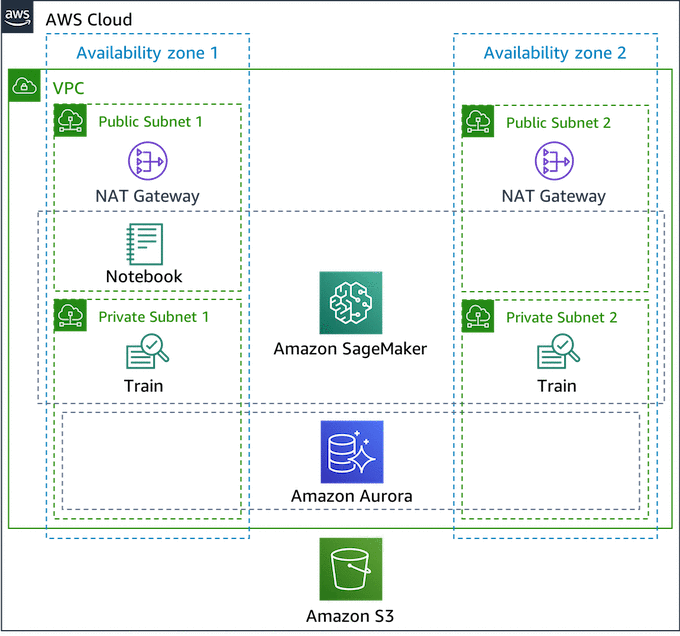

In [1]:
from IPython.display import Image
file_name1 = './img/optuna.gif'
Image(file_name1)

### Setup
After you create an AWS environment by the CloudFormation template, install Optuna and MySQL connector to the notebook kernel, obtain parameters from the CloudFormation Outputs, and get DB secrets from AWS Secrets Manager. Please modify the '<your_cfn_stack_name>' to your CloudFormation stack name, which you can find at AWS Management Console.

In [ ]:
!pip install optuna==1.4.0
!pip install PyMySQL==0.9.3

In [ ]:
import optuna
import PyMySQL
# obtain parameters from CloudFormation Outputs
stack_name = '<your_cfn_stack_name>'

client = boto3.client('cloudformation')
outputs = client.describe_stacks(StackName=stack_name)['Stacks'][0]['Outputs']

host = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'ClusterEndpoint'][0].split(':')[0]
db_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DatabaseName'][0]
secret_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DBSecretArn'][0].split(':')[-1].split('-')[0]

subnets = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'PrivateSubnets'][0].split(',')
security_group_ids = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'SageMakerSecurityGroup'][0].split(',')

In [ ]:
# Call AWS Secrets Manager
from src.secrets import get_secret
region_name = boto3.session.Session().region_name
secret = get_secret(secret_name, region_name)

# PyMySQL https://docs.sqlalchemy.org/en/13/dialects/mysql.html#module-sqlalchemy.dialects.mysql.pymysql   
db = 'mysql+pymysql://{}:{}@{}/{}'.format(secret['username'], secret['password'], host, db_name)

In [ ]:
sagemaker_session   = sagemaker.Session()
bucket = sagemaker_session.default_bucket()                     
prefix = 'optuna'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sagemaker_session)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

## Trainig a model

We demonstrate an Optuna example [pytorch_simple.py](https://github.com/optuna/optuna/blob/master/examples/pytorch_simple.py) migrated to Amazon SageMaker

In [ ]:
# create study in RDS/Aurora
study_name = 'pytorch-simple'
optuna.study.create_study(storage=db, study_name=study_name, direction='maximize', load_if_exists=True)

In [ ]:
# data preparation 
from torchvision import datasets
from torchvision import transforms

dataset = datasets.MNIST(root='./data/MNIST/', train=True, download=True, transform=transforms.ToTensor())

In [ ]:
input_data = sagemaker_session.upload_data(path='./data/MNIST/',key_prefix='pytorch_mnist')

In [ ]:
# setup SageMaker PyTorch estimator
from sagemaker.pytorch.estimator import PyTorch
 
pytorch_estimator = PyTorch(entry_point='./tools/pytorch_simple.py',
                            #source_dir="tools",
                            framework_version='1.5.0',
                            role=role,
                            subnets=subnets,
                            security_group_ids=security_group_ids,
                            train_instance_count=1,
                            train_instance_type='ml.c4.xlarge',
                            hyperparameters={
                                'host': host,
                                'db-name': db_name,
                                'db-secret': secret_name,
                                'study-name': study_name,
                                'region-name': region_name,
                                'n-trials': 25
                            })

In [ ]:
# Hyper Parameter Optimization in parallel
max_parallel_jobs = 4
for j in range(max_parallel_jobs-1):
    pytorch_estimator.fit({'train': train_input, 'test': test_input}, wait=False)
pytorch_estimator.fit({'train': train_input, 'test': test_input})

You can see the console output during training in Jupyter Notebook. Models are saved every time in the objective() function. Only trials that are optimal in each training job are moved to model_dir and stored in Amazon S3. The Amazon SageMaker training job ID is recorded in the user attribute of the trial for retrieval. This makes it easy to get the Amazon S3 object key where the best model is stored when the inference endpoint is deployed.

You can visualize the result when the training job is complete. Retrieve the result as pandas.DataFrame. See the following code:

In [ ]:
study = optuna.study.load_study(study_name=study_name, storage=db)
df = study.trials_dataframe()

ax = df['value'].plot()
ax.set_xlabel('Number of trials')
ax.set_ylabel('Validation accuracy')

Through repeated trials, you can search for better hyperparameters and confirm that the accuracy has improved

## Creating the inference endpoint

In [ ]:
from sagemaker.pytorch import PyTorchModel
 
best_model_data = '{}/{}/output/model.tar.gz'.format(pytorch_estimator.output_path, study.best_trial.user_attrs['job_name'])
best_model = PyTorchModel(model_data=best_model_data,
                          role=role,
                          entry_point='./tools/pytorch_simple.py',
                          #source_dir="src",
                          framework_version='1.5.0'
                         )
 
predictor = best_model.deploy(instance_type="ml.p2.xlarge", initial_instance_count=1)

By sending images to the endpoint for trial, you can get the result of the inference. See the following code:

In [ ]:
import torch

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
        batch_size=5,
        shuffle=True,
    )
 
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.view(-1, 28 * 28).to('cpu'), target.to('cpu')
   
    prediction = predictor.predict(data)
    predicted_label = prediction.argmax(axis=1)
    print('Pred label: {}'.format(predicted_label))
    print('True label: {}'.format(target.numpy()))
    break

## Close Endpoint

In [ ]:
predictor.delete_endpoint()

Reference:
https://github.com/aws-samples/amazon-sagemaker-optuna-hpo-blog/blob/master/examples/pytorch_simple/pytorch_simple.ipynb

https://aws.amazon.com/ko/blogs/machine-learning/implementing-hyperparameter-optimization-with-optuna-on-amazon-sagemaker/

https://github.com/aws/sagemaker-pytorch-training-toolkit